
Simulate forcing ACL pathway in the NP11 model.And observe what happens with XPK. 
* You can  make a graph with flux of (phosphoketolase (fructose 6-phosphate)) on y axis and ACL on x axis, if you do forcing simulations in few steps. You will obtain like a linear line. 
* FBA params: I suggest Glc max at 0.05 GR and another round for 0.3 GR. 
* And extract cofactor balances, and compare how it changes when ACL is forced to have a flux. Especially NADH.



In [4]:
import cobra
import pandas as pd
import os
from os.path import join
from cobra import Model, Reaction, Metabolite
from cobra.sampling import sampling
import numpy as np
os.environ["R_HOME"] = f"{os.environ['CONDA_PREFIX']}\\Lib\\R"
import rpy2.robjects
from plotnine import *
import matplotlib.pyplot as plt

In [5]:
# For getting IDs of all rxns
model1=cobra.io.read_sbml_model("C:\\Users\\Maive\\Desktop\\BSc_loputoo\\Model_files\\NP11\\rhto.xml")

model1.objective = 'r_1714' # glc ex rxn
solution1 = model1.optimize()
all_fluxes = solution1.fluxes.to_frame(name='Flux')

In [6]:
# Glc max at 0.05 GR and another round for 0.3 GR

ACITL_c_bounds = [0.187384,0.456413,0.681589,0.95863,1.109162,1.293863]
growth_rates = [0.049, 0.100, 0.151, 0.203, 0.25, 0.301]

all_fluxes_glc_max = pd.DataFrame(columns=['Glucose uptake', 'Growth rate', *all_fluxes.index], index=range(len(growth_rates))) #flux_values.index gives the row names column, * extracts the list of strings

for i in range(len(growth_rates)):
    model=cobra.io.read_sbml_model("C:\\Users\\Maive\\Desktop\\BSc_loputoo\\Model_files\\NP11\\rhto.xml")
    model.reactions.r_4041.bounds = growth_rates[i], growth_rates[i]
    model.reactions.y200003.bounds = ACITL_c_bounds[i], ACITL_c_bounds[i]
    model.reactions.r_1714.bounds = -9999, 9999
    model.objective = 'r_1714'
    solution = model.optimize()
    all_fluxes_glc_max.loc[i] = solution.fluxes[['r_1714', 'r_4041', *all_fluxes.index]].values
    
all_fluxes_glc_max

,Glucose uptake,Growth rate,r_0001,r_0002,r_0003,r_0004,r_0005,r_0006,r_0007,r_0012,...,y300064,y300065,y300066,y300068,y300069,y300070,y300072,y300074,y300075,y300078
0,-0.701113,0.049,0.0,0.0,0.0,0.0,0.052839,0.017649,0.002654,0.0,...,0.0,0.008695,-0.008695,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,-1.324147,0.1,0.0,0.0,0.0,0.0,0.107835,0.036019,0.005417,0.0,...,0.0,0.086358,-0.086358,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,-1.945979,0.151,0.0,0.0,0.0,0.0,0.16283,0.054389,0.008179,0.0,...,0.0,0.1304,-0.1304,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,-2.581786,0.203,0.0,0.0,0.0,0.0,0.218904,0.073119,0.010996,0.0,...,0.0,0.175306,-0.175306,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,-3.152893,0.25,0.0,0.0,0.0,0.0,0.269586,0.090048,0.013542,0.0,...,0.0,0.197485,-0.197485,0.0,0.0,0.0,0.0,0.0,0.0,0.0
5,-3.773789,0.301,0.0,0.0,0.0,0.0,0.324582,0.108418,0.016304,0.0,...,0.0,0.196204,-0.196204,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [7]:
# Exchange fluxes
exchange_fluxes_table = all_fluxes_glc_max[['r_4041', 'r_1714', 'r_1992', 'r_1654','r_2060','r_2005', 'r_1672']]

for i in range(len(exchange_fluxes_table.columns)):
    exchange_fluxes_table = exchange_fluxes_table.rename(columns = {exchange_fluxes_table.columns[i]: getattr(model.reactions, exchange_fluxes_table.columns[i]).name})

exchange_fluxes_table

,biomass pseudoreaction,D-glucose exchange,oxygen exchange,ammonium exchange,sulphate exchange,phosphate exchange,carbon dioxide exchange
0,0.049,-0.701113,-2.023758,-0.201366,-0.004165,-0.010765,2.18399
1,0.1,-1.324147,-3.489948,-0.41095,-0.008501,-0.021969,3.816952
2,0.151,-1.945979,-4.948913,-0.620535,-0.012836,-0.033174,5.442691
3,0.203,-2.581786,-6.447183,-0.834229,-0.017257,-0.044598,7.111004
4,0.25,-3.152893,-7.780003,-1.027376,-0.021252,-0.054923,8.597517
5,0.301,-3.773789,-9.233359,-1.236961,-0.025588,-0.066128,10.217645


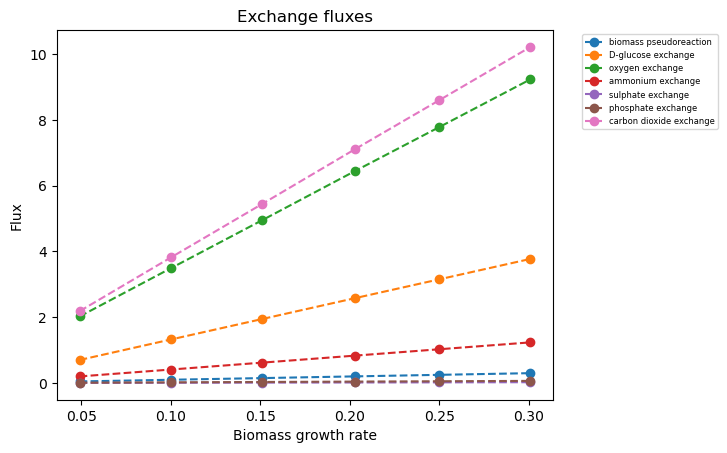

In [11]:
# Exchange fluxes plot

plt.plot(growth_rates, np.abs(exchange_fluxes_table[exchange_fluxes_table.columns]), 'o--', label = exchange_fluxes_table.columns)

plt.xlabel('Biomass growth rate')
plt.ylabel('Flux')
plt.title("Exchange fluxes")
plt.legend(fontsize=6, loc='upper left', bbox_to_anchor=(1.05, 1))
# plt.yticks(range(0, 20, 1))
plt.show()

In [8]:
PPP_fluxes = all_fluxes_glc_max[['r_4041', 'r_1714', 'r_0466', 'r_1049', 'r_1048','r_1050', 't_0081', 'r_0450','r_0959','r_0961']]
# Change G6PDH2rp column name to oxpp 

for i in range(len(PPP_fluxes.columns)):
    PPP_fluxes = PPP_fluxes.rename(columns = {PPP_fluxes.columns[i]: getattr(model.reactions, PPP_fluxes.columns[i]).name})

PPP_fluxes = PPP_fluxes.rename(columns = {'glucose 6-phosphate dehydrogenase': 'oxpp'})
PPP_fluxes

,biomass pseudoreaction,D-glucose exchange,oxpp,transketolase 1,transaldolase,transketolase 2,phosphoketolase,fructose-bisphosphate aldolase,pyruvate decarboxylase,pyruvate dehydrogenase
0,0.049,-0.701113,0.284988,0.093172,0.0,0.084878,0.0,0.342113,0.0,0.778456
1,0.1,-1.324147,0.562119,0.183649,0.0,0.166724,0.0,0.604489,0.0,1.411425
2,0.151,-1.945979,0.8488,0.277311,0.0,0.251753,0.0,0.859294,0.0,2.024282
3,0.203,-2.581786,1.141102,0.372809,-1.120878,0.33845,0.0,0.0,0.0,2.652722
4,0.25,-3.152893,1.414502,0.462192,0.0,0.419878,0.0,1.347609,0.0,3.210539
5,0.301,-3.773789,1.714947,0.560442,-1.592303,0.509495,0.0,0.0,0.0,3.799143


In [9]:
# ATPM and ACITL fluxes - didn't find the ID for ATPM
ATPM_ACITL_fluxes = all_fluxes_glc_max[['r_4041', 'r_1714', 'y200003']] #Didnt find the ID for ATP maintainance rxn, ACS - Acetyl-CoA synthetase
for i in range(len(ATPM_ACITL_fluxes.columns)):
    ATPM_ACITL_fluxes = ATPM_ACITL_fluxes.rename(columns = {ATPM_ACITL_fluxes.columns[i]: getattr(model.reactions, ATPM_ACITL_fluxes.columns[i]).name})

ATPM_ACITL_fluxes

,biomass pseudoreaction,D-glucose exchange,ATP-citrate lyase
0,0.049,-0.701113,0.187384
1,0.1,-1.324147,0.456413
2,0.151,-1.945979,0.681589
3,0.203,-2.581786,0.95863
4,0.25,-3.152893,1.109162
5,0.301,-3.773789,1.293863


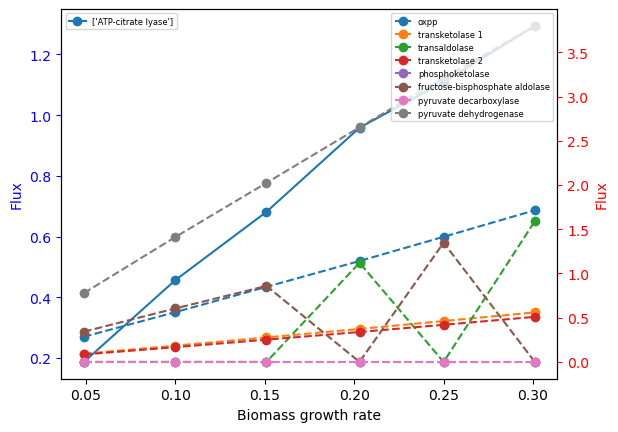

In [10]:
# Plot the PPP enzymes fluxes with ATPM and ACITL on seperate y-axis

# Sample data
x = growth_rates
y1 = np.abs(ATPM_ACITL_fluxes[['ATP-citrate lyase']])
y2 = np.abs(PPP_fluxes[['oxpp', 'transketolase 1', 'transaldolase', 'transketolase 2',	'phosphoketolase',	'fructose-bisphosphate aldolase',	'pyruvate decarboxylase',	'pyruvate dehydrogenase']])

fig, ax1 = plt.subplots()

ax1.plot(x, y1, 'o-', label=['ATP-citrate lyase'])
ax1.set_xlabel('Biomass growth rate')
ax1.set_ylabel('Flux', color='b')
ax1.tick_params('y', colors='b')
ax1.legend(fontsize=6, loc='upper left')

# Create the second y-axis on the right
ax2 = ax1.twinx()

# Plot the second set of data on the right y-axis 
ax2.plot(x, y2, 'o--', label=['oxpp', 'transketolase 1', 'transaldolase', 'transketolase 2',	'phosphoketolase',	'fructose-bisphosphate aldolase',	'pyruvate decarboxylase',	'pyruvate dehydrogenase'])
ax2.set_ylabel('Flux', color='r')
ax2.tick_params('y', colors='r')
ax2.legend(fontsize=6, loc='upper right')

# Show the plot
plt.show()

Text(0.5, 1.0, 'ATP citrate lyase vs phosphoketolase (fructose 6-phosphate)')

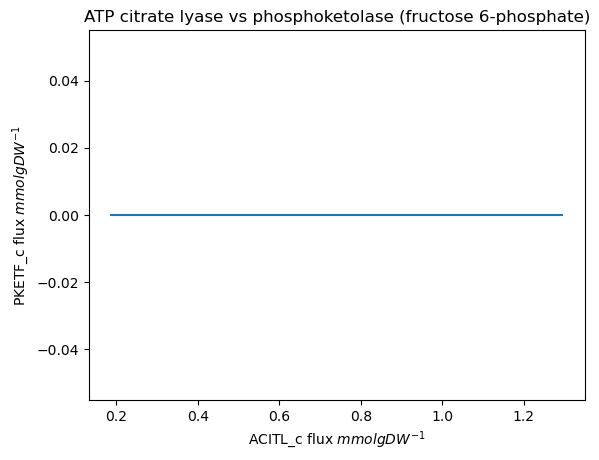

In [12]:
# PKETF_c on y and ACITL on x

plt.plot(ATPM_ACITL_fluxes['ATP-citrate lyase'], PPP_fluxes['phosphoketolase'], '-')
plt.xlabel(r'ACITL_c flux $mmol gDW^{−1}$')
plt.ylabel(r'PKETF_c flux $mmol gDW^{−1}$')
plt.title('ATP citrate lyase vs phosphoketolase (fructose 6-phosphate)')

In [13]:
# Cofactor lists
nadphs = ['s_1212', 's_1213', 's_1214', 's_1215', 's_2799','s_2952']
nadhs = ['s_1203', 's_1204', 's_1205', 's_1206', 's_1206', 's_3753']
atps = ['s_0434', 's_0435', 's_0437', 's_3881', 's_0438', 's_0439', 's_3359', 's_2840', 's_2831', 's_2856', 's_3341'] 

# Make a function for getting cofactor fluxes (all reactions where given metabolite is and their fluxes)

def cofactor_all_rxn_fluxes(cofactor_list, i):
    producing_fluxes = pd.DataFrame() 
    consuming_fluxes = pd.DataFrame()
    
    model=cobra.io.read_sbml_model("C:\\Users\\Maive\\Desktop\\BSc_loputoo\\Model_files\\NP11\\rhto.xml")   
    model.reactions.r_4041.bounds = growth_rates[i], growth_rates[i]
    model.reactions.r_1714.bounds = -9999, 9999
    model.reactions.y200003.bounds = ACITL_c_bounds[i], ACITL_c_bounds[i]
    model.objective = 'r_1714'
    solution = model.optimize()

    for metabolite in cofactor_list:
        producing_fluxes = pd.concat([producing_fluxes, getattr(model.metabolites, metabolite).summary().producing_flux])
        consuming_fluxes = pd.concat([consuming_fluxes, getattr(model.metabolites, metabolite).summary().consuming_flux])
    
    for reaction in producing_fluxes.index:
        if reaction in consuming_fluxes.index and abs(round(producing_fluxes.loc[reaction, 'flux'], 3)) == abs(round(consuming_fluxes.loc[reaction, 'flux'], 3)):
            producing_fluxes = producing_fluxes.drop([reaction])
            consuming_fluxes = consuming_fluxes.drop([reaction])
            
    cofactor_fluxes = pd.concat([producing_fluxes, consuming_fluxes])

    cofactor_fluxes = cofactor_fluxes.sort_values(by='flux', ascending=False).drop(columns = ['percent']) # drop percent column, bc these percents are not for nadph sum (the percent is for specific compartment)
    cofactor_fluxes = cofactor_fluxes[(cofactor_fluxes['flux']) != 0.0] # for getting non-zero fluxes only

    cofactor_sum_producing_flux = sum(cofactor_fluxes[cofactor_fluxes['flux'] > 0]['flux']) # for getting the sum of producing fluxes
    cofactor_sum_consuming_flux = sum(cofactor_fluxes[cofactor_fluxes['flux'] < 0]['flux']) # for getting the sum of consumed fluxes
    print(f'SUM produced: {cofactor_sum_producing_flux}, SUM consumed: {cofactor_sum_consuming_flux}')

    if round(cofactor_sum_producing_flux, 3) == round(abs(cofactor_sum_consuming_flux), 3):
        cofactor_fluxes['percent'] = abs(cofactor_fluxes['flux']/cofactor_sum_producing_flux) # add percent column

    return cofactor_fluxes

# Making a pie chart
def cofactor_fluxes_pie_chart(cofactor_fluxes,  title, threshold): # threshold shows the percent of the flux for including in others sector on pie chart 
    import plotly.graph_objects as go
    # The three lines below are for grouping together reactions with low fluxes in producing
    producing_cofactor_fluxes_draw = cofactor_fluxes[(cofactor_fluxes['flux'] > 0).copy()]    
    producing_cofactor_fluxes_draw.loc[producing_cofactor_fluxes_draw['percent'] < threshold, 'reaction'] = 'Other producing'
    producing_cofactor_fluxes_draw = producing_cofactor_fluxes_draw.groupby('reaction')[['percent', 'flux']].sum()        
    
    # The three lines below are for grouping together reactions with low fluxes in consuming 
    consuming_cofactor_fluxes_draw = cofactor_fluxes[(cofactor_fluxes['flux'] < 0).copy()]
    consuming_cofactor_fluxes_draw.loc[consuming_cofactor_fluxes_draw['percent'] < threshold, 'reaction'] = 'Other consuming'
    consuming_cofactor_fluxes_draw = consuming_cofactor_fluxes_draw.groupby('reaction')[['percent', 'flux']].sum()
    
    # y_producing = producing_cofactor_fluxes_draw['percent']
    # labels_producing = producing_cofactor_fluxes_draw[['reaction', 'flux']] 
    
    # y_consuming = abs(consuming_cofactor_fluxes_draw['percent'])
    # labels_consuming = consuming_cofactor_fluxes_draw[['reaction', 'flux']]
    
    producing_and_consuming_fluxes = pd.concat([producing_cofactor_fluxes_draw, consuming_cofactor_fluxes_draw])
    
    # reaction_IDs = pd.concat([labels_producing, labels_consuming])
    model=cobra.io.read_sbml_model("C:\\Users\\Maive\\Desktop\\BSc_loputoo\\Model_files\\NP11\\rhto.xml")   
    model.objective = 'r_1714'
    solution = model.optimize()
    
    reaction_names_w_flux = []
    for reaction in producing_and_consuming_fluxes.index:
        if reaction != 'Other producing' and reaction != 'Other consuming':
            reaction_names_w_flux += [', '.join([''.join([str(round((producing_and_consuming_fluxes.loc[reaction, 'percent'])*100, 1)),'%']), getattr(model.reactions, reaction).name, str(round(producing_and_consuming_fluxes.loc[reaction, 'flux'], 3))])]
        elif reaction == 'Other producing':
            reaction_names_w_flux += [', '.join([''.join([str(round((producing_and_consuming_fluxes.loc[reaction, 'percent'])*100, 1)),'%']), 'Other producing', str(round(producing_and_consuming_fluxes.loc[reaction, 'flux'], 3))])] 
        elif reaction == 'Other consuming':
            reaction_names_w_flux += [', '.join([''.join([str(round((producing_and_consuming_fluxes.loc[reaction, 'percent'])*100, 1)),'%']), 'Other consuming', str(round(producing_and_consuming_fluxes.loc[reaction, 'flux'], 3))])] 
            
    pie_chart = plt.pie(producing_and_consuming_fluxes.loc[:, 'percent'], labels = reaction_names_w_flux)  #autopct='%1.1f%%' pd.concat([producing_cofactor_fluxes_draw, consuming_cofactor_fluxes_draw])[['flux', 'percent']]
    # plt.legend(producing_and_consuming_fluxes, reaction_names_w_flux, title = 'Reaction names', loc="center left",  bbox_to_anchor=(1, 0, 0.5, 1))
    plt.title(title)
    plt.show()  
    
    return pie_chart


In [14]:
# Get nadph fluxes at lowest biomass growth rate

nadph_fluxes_lowest_GR = cofactor_all_rxn_fluxes(nadphs, 0)
nadph_fluxes_lowest_GR

# Get nadph fluxes at highest biomass growth rate

nadph_fluxes_highest_GR = cofactor_all_rxn_fluxes(nadphs, 5)
nadph_fluxes_highest_GR

# Get nadh fluxes at lowest biomass growth rate

nadh_fluxes_lowest_GR = cofactor_all_rxn_fluxes(nadhs, 0)
nadh_fluxes_lowest_GR

# Get nadh fluxes at highest biomass growth rate

nadh_fluxes_highest_GR = cofactor_all_rxn_fluxes(nadhs, 5)
nadh_fluxes_highest_GR

# Get atp fluxes at lowest biomass growth rate

atp_fluxes_lowest_GR = cofactor_all_rxn_fluxes(atps, 0)
atp_fluxes_lowest_GR

# Get nadph fluxes at highest biomass growth rate

atp_fluxes_highest_GR = cofactor_all_rxn_fluxes(atps, 5)
atp_fluxes_highest_GR

SUM produced: 0.6233542418655107, SUM consumed: -0.6233542418655106
SUM produced: 3.757784138602424, SUM consumed: -3.7577841386024224
SUM produced: 4.512334544657607, SUM consumed: -4.512334544657607
SUM produced: 21.4648275509116, SUM consumed: -21.464827550911604
SUM produced: 12.067880468113794, SUM consumed: -12.067880468113792
SUM produced: 55.62839042186683, SUM consumed: -55.62839042186684


,flux,reaction,percent
r_0226,44.190769,r_0226,0.794392
r_0892,4.795904,r_0892,0.086213
r_0962,4.308029,r_0962,0.077443
r_1022,2.085702,r_1022,0.037493
r_0447,0.244375,r_0447,0.004393
...,...,...,...
y200003,-1.293863,y200003,0.023259
r_0886,-1.592303,r_0886,0.028624
r_4046,-3.392800,r_4046,0.060990
r_0534,-3.773789,r_0534,0.067839


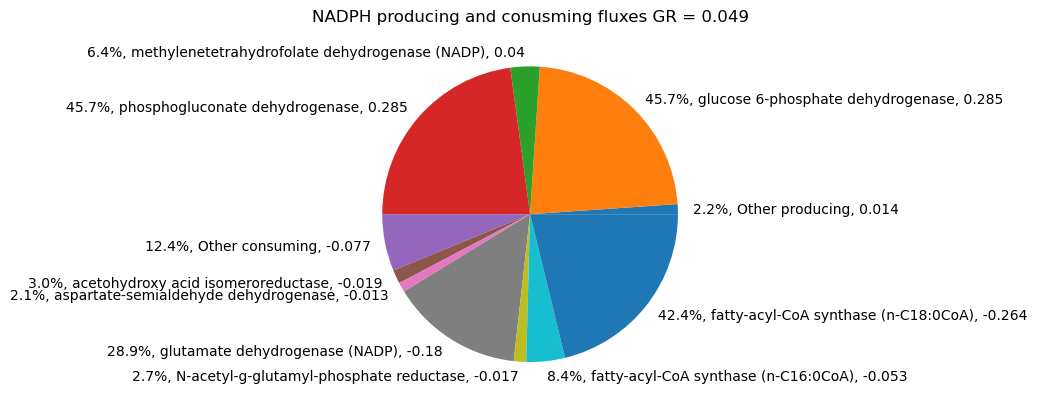

([<matplotlib.patches.Wedge at 0x24ce5d12c90>,
 [Text(1.0993545264535425, 0.0376779135052316, '2.2%, Other producing, 0.014'),
  Text(0.7768324903467841, 0.7788011825502152, '45.7%, glucose 6-phosphate dehydrogenase, 0.285'),
  Text(-0.037677884556450526, 1.0993545274456966, '6.4%, methylenetetrahydrofolate dehydrogenase (NADP), 0.04'),
  Text(-0.8283303240966671, 0.7237878654563854, '45.7%, phosphogluconate dehydrogenase, 0.285'),
  Text(-1.079096675482915, -0.21342531471622678, '12.4%, Other consuming, -0.077'),
  Text(-0.9964161342821135, -0.4659988061597254, '3.0%, acetohydroxy acid isomeroreductase, -0.019'),
  Text(-0.9559457086303514, -0.5442130117437614, '2.1%, aspartate-semialdehyde dehydrogenase, -0.013'),
  Text(-0.5895235185121933, -0.9286883336841288, '28.9%, glutamate dehydrogenase (NADP), -0.18'),
  Text(-0.0753425485453776, -1.097416739611114, '2.7%, N-acetyl-g-glutamyl-phosphate reductase, -0.017'),
  Text(0.11698912288331961, -1.0937611920007912, '8.4%, fatty-acyl-CoA

In [15]:
# Make a pie plot for napdh
threshold = 0.02 # threshold for including reaction in 'others' in pie chart
title = f'NADPH producing and conusming fluxes GR = {growth_rates[0]}'
producing_nadph_fluxes_lowest_GR_pie_chart = cofactor_fluxes_pie_chart(nadph_fluxes_lowest_GR, title, threshold)
producing_nadph_fluxes_lowest_GR_pie_chart


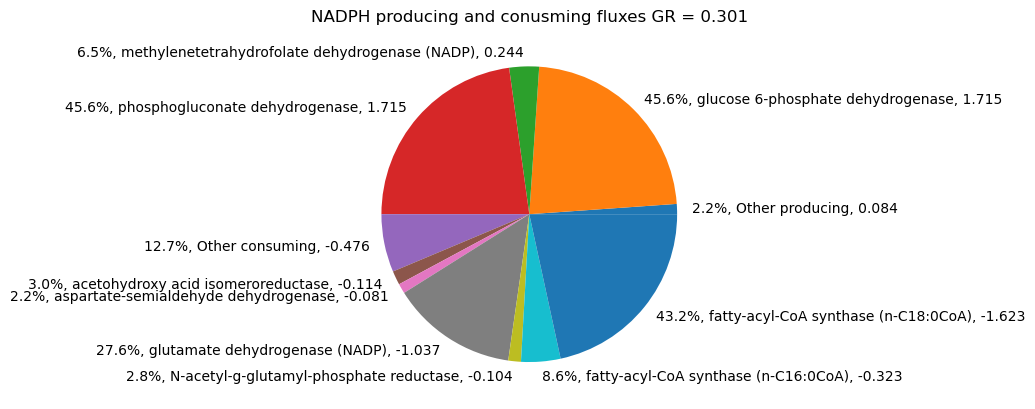

([<matplotlib.patches.Wedge at 0x24ce67fa270>,
 [Text(1.0993297699536613, 0.038393448576940804, '2.2%, Other producing, 0.084'),
  Text(0.7768137414334163, 0.7788198836189391, '45.6%, glucose 6-phosphate dehydrogenase, 1.715'),
  Text(-0.03839347752506987, 1.0993297689426644, '6.5%, methylenetetrahydrofolate dehydrogenase (NADP), 0.244'),
  Text(-0.8292544913619476, 0.7227288485704979, '45.6%, phosphogluconate dehydrogenase, 1.715'),
  Text(-1.0782973294937106, -0.21742784827784267, '12.7%, Other consuming, -0.476'),
  Text(-0.9925081059459655, -0.47426538945146773, '3.0%, acetohydroxy acid isomeroreductase, -0.114'),
  Text(-0.9505478027194055, -0.5535872783448968, '2.2%, aspartate-semialdehyde dehydrogenase, -0.081'),
  Text(-0.59946786655009, -0.9223005350610416, '27.6%, glutamate dehydrogenase (NADP), -1.037'),
  Text(-0.1094792846973455, -1.0945383895607124, '2.8%, N-acetyl-g-glutamyl-phosphate reductase, -0.104'),
  Text(0.08652141812313048, -1.0965920135610885, '8.6%, fatty-acyl

In [16]:
# Make a pie plot for napdh
threshold = 0.02 # threshold for including reaction in 'others' in pie chart
title = f'NADPH producing and conusming fluxes GR = {growth_rates[5]}'
producing_nadph_fluxes_highest_GR_pie_chart = cofactor_fluxes_pie_chart(nadph_fluxes_highest_GR, title, threshold)
producing_nadph_fluxes_highest_GR_pie_chart


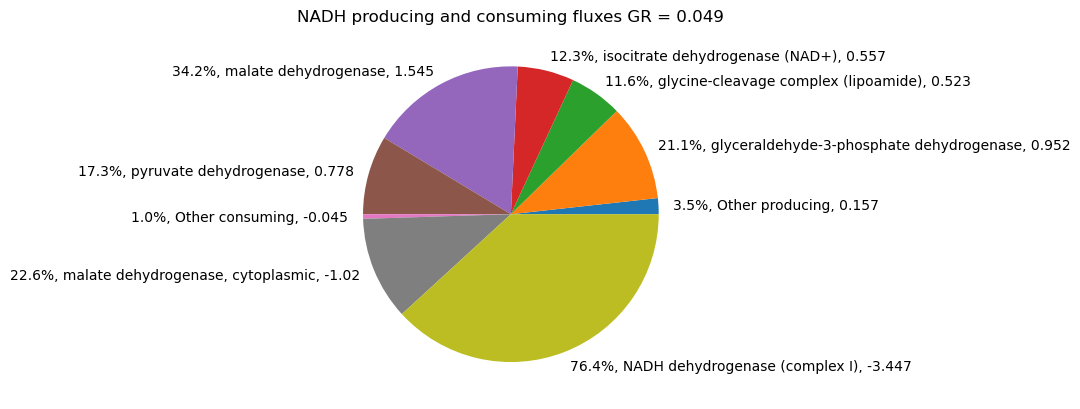

([<matplotlib.patches.Wedge at 0x24ce90746e0>,
 [Text(1.0983534602376768, 0.06016374642525479, '3.5%, Other producing, 0.157'),
  Text(0.9947744689477861, 0.46949308400619755, '21.1%, glyceraldehyde-3-phosphate dehydrogenase, 0.952'),
  Text(0.6358472366598741, 0.8976069806056559, '11.6%, glycine-cleavage complex (lipoamide), 0.523'),
  Text(0.2619623669974108, 1.0683518700676824, '12.3%, isocitrate dehydrogenase (NAD+), 0.557'),
  Text(-0.518778361689246, 0.9699840263854979, '34.2%, malate dehydrogenase, 1.545'),
  Text(-1.0598570623394836, 0.29445374409085057, '17.3%, pyruvate dehydrogenase, 0.778'),
  Text(-1.099863954037325, -0.017299786396977893, '1.0%, Other consuming, -0.045'),
  Text(-1.0188125309090197, -0.4147541764259378, '22.6%, malate dehydrogenase, cytoplasmic, -1.02'),
  Text(0.3986799597004266, -1.0252093882389424, '76.4%, NADH dehydrogenase (complex I), -3.447')])

In [17]:
# Make a pie plot for nadh 
threshold = 0.02 # threshold for including reaction in group 'others' in pie chart
title = f'NADH producing and consuming fluxes GR = {growth_rates[0]}'
producing_nadh_fluxes_lowest_GR_pie_chart = cofactor_fluxes_pie_chart(nadh_fluxes_lowest_GR, title, threshold)
producing_nadh_fluxes_lowest_GR_pie_chart

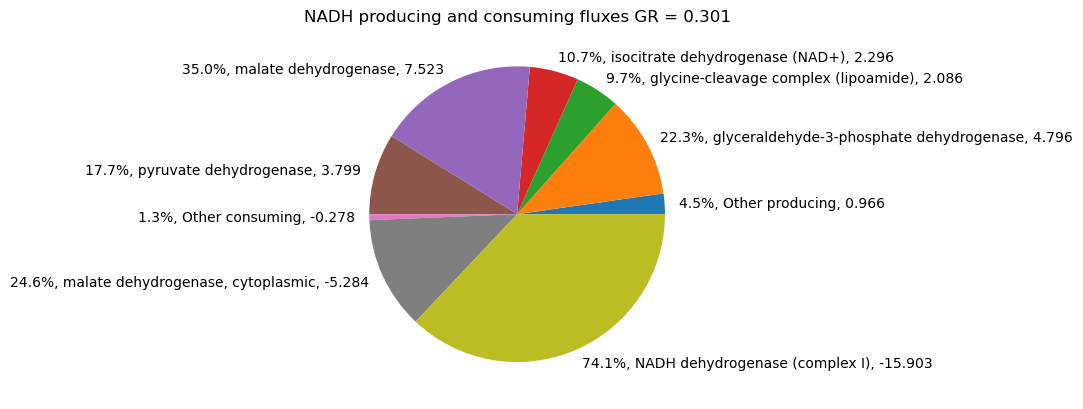

([<matplotlib.patches.Wedge at 0x24cebf75ac0>,
 [Text(1.09725472220729, 0.07766643157634749, '4.5%, Other producing, 0.966'),
  Text(0.9693762302128638, 0.519913189194405, '22.3%, glyceraldehyde-3-phosphate dehydrogenase, 4.796'),
  Text(0.5981320533069124, 0.923167399124805, '9.7%, glycine-cleavage complex (lipoamide), 2.086'),
  Text(0.27669132406629265, 1.0646322891902358, '10.7%, isocitrate dehydrogenase (NAD+), 2.296'),
  Text(-0.49252324190768637, 0.9835755467582259, '35.0%, malate dehydrogenase, 7.523'),
  Text(-1.0577603960311956, 0.3018988979574594, '17.7%, pyruvate dehydrogenase, 3.799'),
  Text(-1.099773135654281, -0.022339429114248303, '1.3%, Other consuming, -0.278'),
  Text(-1.0010850209832203, -0.4558824198880951, '24.6%, malate dehydrogenase, cytoplasmic, -5.284'),
  Text(0.43545772786267656, -1.0101369051988327, '74.1%, NADH dehydrogenase (complex I), -15.903')])

In [18]:
# Make a pie plot for nadh 
threshold = 0.02 # threshold for including reaction in group 'others' in pie chart
title = f'NADH producing and consuming fluxes GR = {growth_rates[5]}'
producing_nadh_fluxes_highest_GR_pie_chart = cofactor_fluxes_pie_chart(nadh_fluxes_highest_GR, title, threshold)
producing_nadh_fluxes_highest_GR_pie_chart


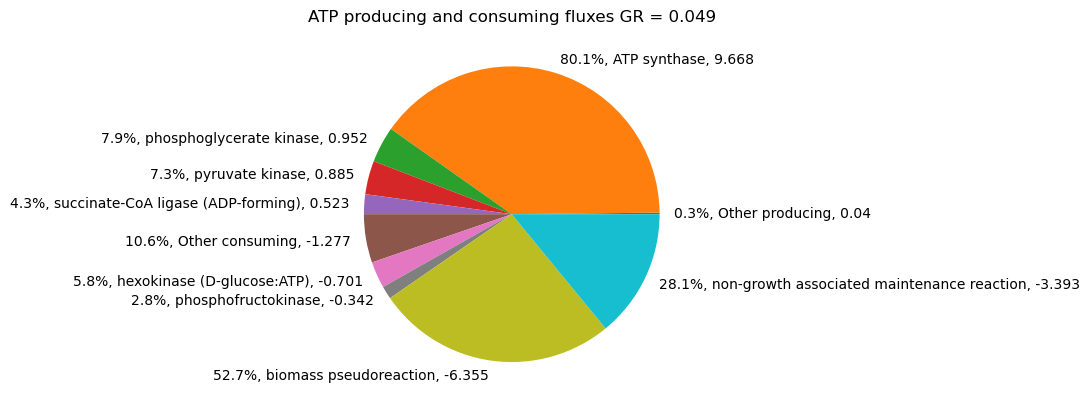

([<matplotlib.patches.Wedge at 0x24cee895400>,
 [Text(1.0999848135450674, 0.005780135830888382, '0.3%, Other producing, 0.04'),
  Text(0.32705341965031337, 1.0502552359760156, '80.1%, ATP synthase, 9.668'),
  Text(-0.9703999020601054, 0.5180000290364258, '7.9%, phosphoglycerate kinase, 0.952'),
  Text(-1.0654692449655667, 0.2734507049405897, '7.3%, pyruvate kinase, 0.885'),
  Text(-1.097454394158617, 0.0747920633619831, '4.3%, succinate-CoA ligase (ADP-forming), 0.523'),
  Text(-1.0848497116875975, -0.18193708542058387, '10.6%, Other consuming, -1.277'),
  Text(-1.0027852729324698, -0.4521301763759552, '5.8%, hexokinase (D-glucose:ATP), -0.701'),
  Text(-0.9323481620862147, -0.5837181722839008, '2.8%, phosphofructokinase, -0.342'),
  Text(-0.15313528975032092, -1.0892885673838155, '52.7%, biomass pseudoreaction, -6.355'),
  Text(0.9944674630498963, -0.4701430260411223, '28.1%, non-growth associated maintenance reaction, -3.393')])

In [19]:
# Make a pie plot for atp 
threshold = 0.02 # threshold for including reaction in group 'others' in pie chart
title = f'ATP producing and consuming fluxes GR = {growth_rates[0]}'
producing_atp_fluxes_lowest_GR_pie_chart = cofactor_fluxes_pie_chart(atp_fluxes_lowest_GR, title,  threshold)
producing_atp_fluxes_lowest_GR_pie_chart

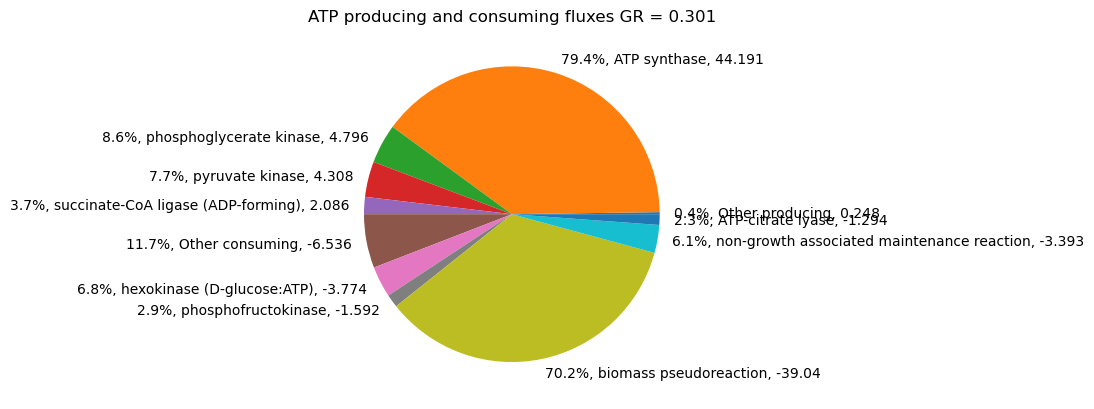

([<matplotlib.patches.Wedge at 0x24ce667af00>,
 [Text(1.0999730309620372, 0.007702672016191356, '0.4%, Other producing, 0.248'),
  Text(0.3344777549697706, 1.0479144198981052, '79.4%, ATP synthase, 44.191'),
  Text(-0.9671769800555314, 0.5239930240477084, '8.6%, phosphoglycerate kinase, 4.796'),
  Text(-1.0686189480484467, 0.2608707416937192, '7.7%, pyruvate kinase, 4.308'),
  Text(-1.0980928289328655, 0.06474673000404699, '3.7%, succinate-CoA ligase (ADP-forming), 2.086'),
  Text(-1.0813193723566583, -0.201862366394043, '11.7%, Other consuming, -6.536'),
  Text(-0.9778816426010397, -0.5037335536411017, '6.8%, hexokinase (D-glucose:ATP), -3.774'),
  Text(-0.890641258934101, -0.6455680815253181, '2.9%, phosphofructokinase, -1.592'),
  Text(0.2225692851985236, -1.0772478420893767, '70.2%, biomass pseudoreaction, -39.04'),
  Text(1.0843520772295818, -0.18487988697500674, '6.1%, non-growth associated maintenance reaction, -3.393'),
  Text(1.0992659230892254, -0.04017997430055515, '2.3%, AT

In [20]:
# Make a pie plot for atp 
threshold = 0.02 # threshold for including reaction in group 'others' in pie chart
title = f'ATP producing and consuming fluxes GR = {growth_rates[5]}'
producing_atp_fluxes_highest_GR_pie_chart = cofactor_fluxes_pie_chart(atp_fluxes_highest_GR, title,  threshold)
producing_atp_fluxes_highest_GR_pie_chart

In [21]:
# # Get all fluxes to excel

# with pd.ExcelWriter('C:\\Users\\Maive\\Desktop\\BSc_loputoo\\Results\\iRhto_results\\iRhto_all_fluxes_glc_max_forced_ACITL.xlsx') as excel_writer:
#     all_fluxes_glc_max.to_excel(excel_writer, sheet_name='Glucose max', index=True)